In [1]:
# imports
from ema_workbench.analysis import parcoords
import pandas as pd
import numpy as np
from ema_workbench import load_results
import seaborn as sns
import os
from model.enums import BeliefUpdate
from dmdu.utils_dmdu import get_lever_names, get_outcome_names
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (14, 10)})

# Overall Plan:
1. avg over replications
2. non-dominated sort -> Pareto-optimal policies
3. parallel axis plots of levers & outcomes (to inspect Pareto-optimal policies)


### 1. Loading the data (results), avg over replications, save into .csv
(can just avg bc replications to make sure that sensitivity to stochasticity is not an issue wrt reproducibility)

# -> TODO: RESCALE LEVER VALUES (*10) (see analyzing_testrun_policies.ipynb)

In [2]:
# Params  # TODO: make a function 'load_my_csv(nfe, bufn, filename, seed=None)' make it also remove the "Unnamed: 0" col
n_repl = 30
bufns = list(BeliefUpdate)  # [BeliefUpdate.DEFFUANT]  # -> BeliefUpdate.list

for bufn in bufns:

    # Loading the results
    filename = "full_factorial" + f"_{n_repl}_replications" + f"_{bufn.name}"
    results_path = os.path.join(os.getcwd(), "data", filename)
    experiments, outcomes = load_results(results_path)

    # Avg over replications
    avgs_outcomes = {}
    for metric in outcomes.keys():
        avgs = np.mean(outcomes[metric], axis=1)
        avgs_outcomes[metric] = avgs

    # Save into .csv  (dict -> df -> .csv)
    avgs_outcomes = pd.DataFrame(avgs_outcomes)
    out_filename = f"outcomes_{bufn.name}.csv"
    path = os.path.join(os.getcwd(), "data", "paretosort", "input", out_filename)
    avgs_outcomes.to_csv(path)

    exp_filename = f"experiments_{bufn.name}.csv"
    path = os.path.join(os.getcwd(), "data", "paretosort", "input", exp_filename)
    experiments.to_csv(path)


### 2. non-dominated sort -> Pareto-optimal policies (& their outcomes)
(via terminal, using the pareto.py script)

w/ epsilon values:
- 2     –– n_agents_above_belief_threshold (maximize)
- 2     –– polarization_variance
- 40    –– engagement (maximize)
- 0.02  –– free_speech_constraint
- 1.0   –– avg_user_effort


### 3. parallel axis plots of levers & outcomes
(to inspect Pareto-optimal policies)


#### a) subset experiments (all 26k policies -> only pareto-optimal policies


In [3]:
# subset experiments (all 26k policies -> only pareto-optimal policies

bufns = list(BeliefUpdate)

for bufn in bufns:
    # load data (all policies)
    exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_{bufn.name}.csv")
    experiments = pd.read_csv(exp_path)

    # get idx that should be kept
    out_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"outcomes_{bufn.name}.csv")
    outcomes = pd.read_csv(out_path)
    column_headers = outcomes.columns
    idx_header = column_headers[0]
    pareto_idx = [x for x in outcomes[idx_header]]

    # subset data + save it (to .csv in output folder)
    subset_exp = experiments[experiments[idx_header].isin(pareto_idx)]
    filename = f"experiments_{bufn.name}.csv"
    path = os.path.join(os.getcwd(), "data", "paretosort", "output", filename)
    subset_exp.to_csv(path)





#### b) Load data files

In [4]:
# Load data files
experiments_dict = {}
outcomes_dict = {}
bufns = list(BeliefUpdate)  # [BeliefUpdate.DEFFUANT]  # -> BeliefUpdate.list

for bufn in bufns:
    # define paths
    exp_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"experiments_{bufn.name}.csv")
    out_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"outcomes_{bufn.name}.csv")
    # load data
    experiments = pd.read_csv(exp_path)
    outcomes = pd.read_csv(out_path)
    # save data
    experiments_dict[bufn.name] = experiments
    outcomes_dict[bufn.name] = outcomes



#### c) Create parallel axis plots

##### Policies (i.e., Levers)

In [5]:
# Policies (i.e., Levers)

def parcoords_levers(exp_dict, bufn, color="blue"):
    """Plots a parallel axis plot for the passed belief update function (bufn)"""

    # Get limits
    exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_{bufn.name}.csv")
    all_exp = pd.read_csv(exp_path)
    only_levers = all_exp[get_lever_names()]
    exp_limits = parcoords.get_limits(only_levers)

    # Parallel axis plot
    axes = parcoords.ParallelAxes(exp_limits)
    data = exp_dict[bufn.name][get_lever_names()]
    axes.plot(data, color=color)


##### DEFFUANT

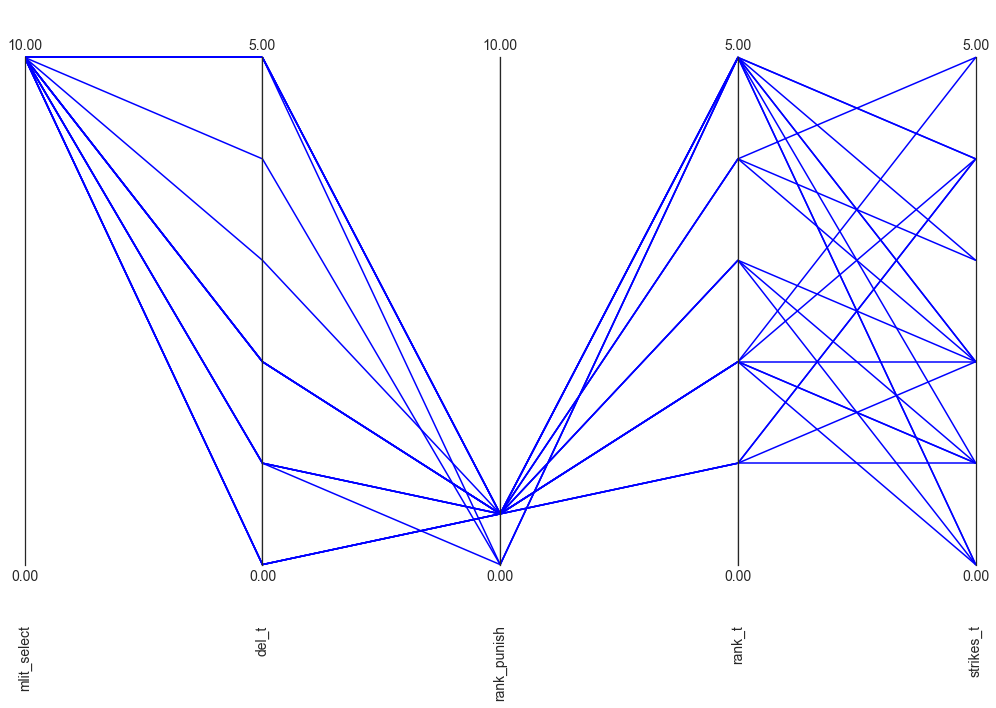

In [6]:
# Get limits of possible levers
bufn = BeliefUpdate.DEFFUANT  # doesn't matter which bufn, all evaluated the same policies
parcoords_levers(experiments_dict, bufn)

##### SAMPLE

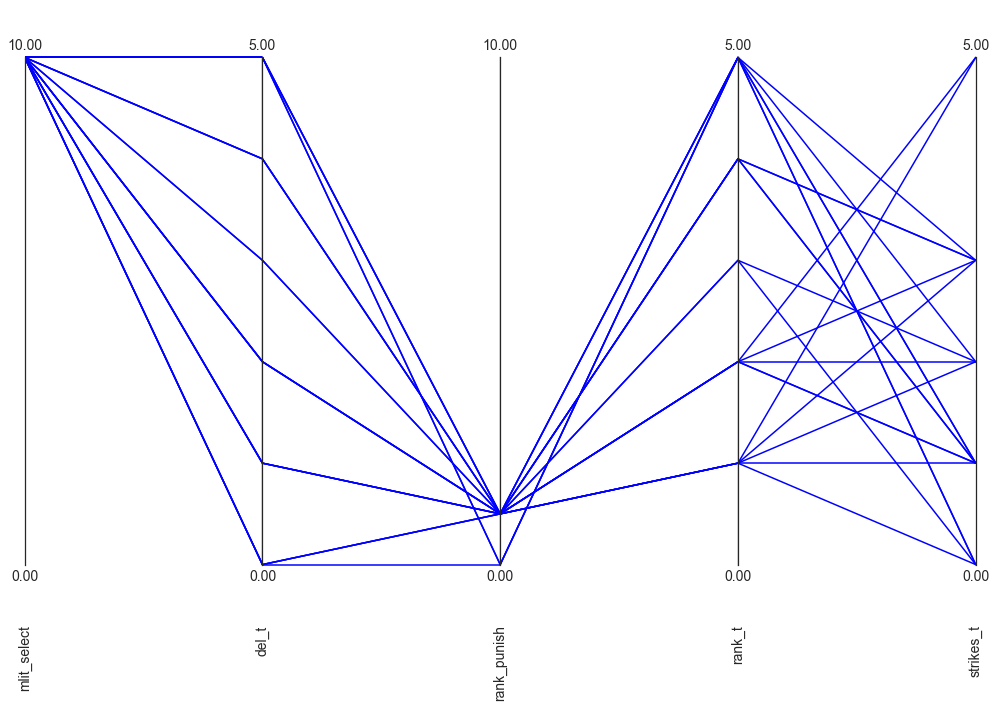

In [7]:
bufn = BeliefUpdate.SAMPLE  # doesn't matter which bufn, all evaluated the same policies
parcoords_levers(experiments_dict, bufn)

##### SIT

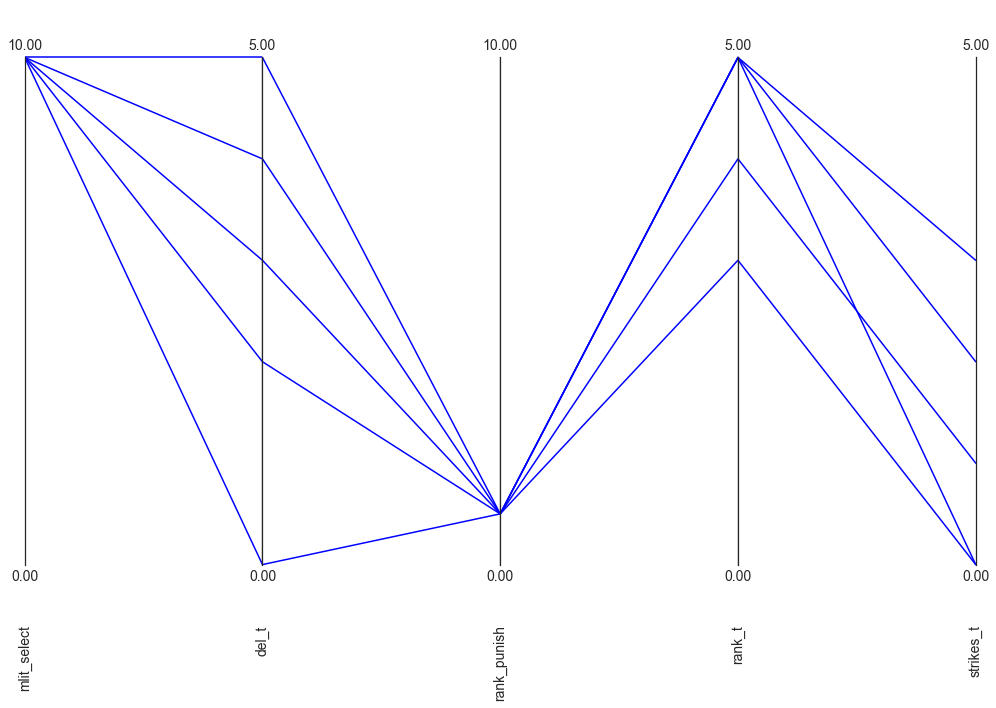

In [8]:
bufn = BeliefUpdate.SIT  # doesn't matter which bufn, all evaluated the same policies
parcoords_levers(experiments_dict, bufn)

##### Combined (no, not easy to see. Few possible values -> many overlaps -> change colors? don't see everything)
# TODO: Would be good to have e.g., densitiy visible over range of lever dimension

In [9]:
# ### Assigning each model a color
# # (This is for when data from multiple models is available.)
#
# model_names = [x.name for x in list(BeliefUpdate)]
#
# # Assign each unique model a color
# model_colors = {}
#
# for _, (model, color) in enumerate(zip(model_names, sns.color_palette("colorblind"))):
#     model_colors[model] = color
#
# for k, v in model_colors.items():
#     print(k,v)

In [10]:
# concat_exp = pd.concat(experiments_dict.values())
#
# # Get limits from input (-> not only Pareto-optimal policies, but all)
# exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_DEFFUANT.csv")
# all_exp = pd.read_csv(exp_path)
# only_levers = all_exp[get_lever_names()]
# exp_limits = parcoords.get_limits(only_levers)

In [11]:
# axes = parcoords.ParallelAxes(exp_limits)
#
# for model_name, data in experiments_dict.items():
#     color = model_colors[model_name]
#
#     # subset data
#     lever_data = data[get_lever_names()]
#     axes.plot(lever_data, color=color)

In [12]:
# # Parallel axis plot
# axes = parcoords.ParallelAxes(exp_limits)
# data = concat_exp[get_lever_names()]
# axes.plot(data)
#

##### Performance (i.e., Outcomes)

In [13]:
# Find limits over all outcomes



In [14]:
def parcoords_outcomes(out_dict, bufn, color="green"):

    # Get limits
    concat_out = pd.concat(out_dict.values())
    out_limits = parcoords.get_limits(concat_out)

    bufn = bufn.name
    axes = parcoords.ParallelAxes(out_limits)

    minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
    for metric in minimize:
        axes.invert_axis(metric)

    axes.plot(outcomes_dict[bufn], color=color)

##### DEFFUANT

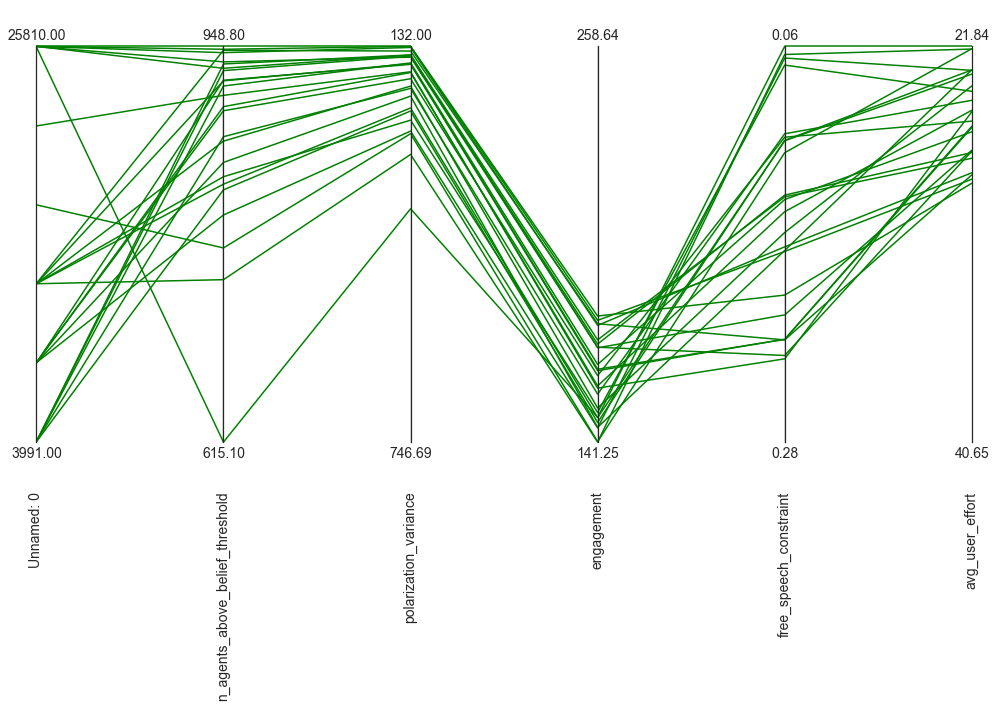

In [15]:
parcoords_outcomes(outcomes_dict, BeliefUpdate.DEFFUANT)

##### SAMPLE

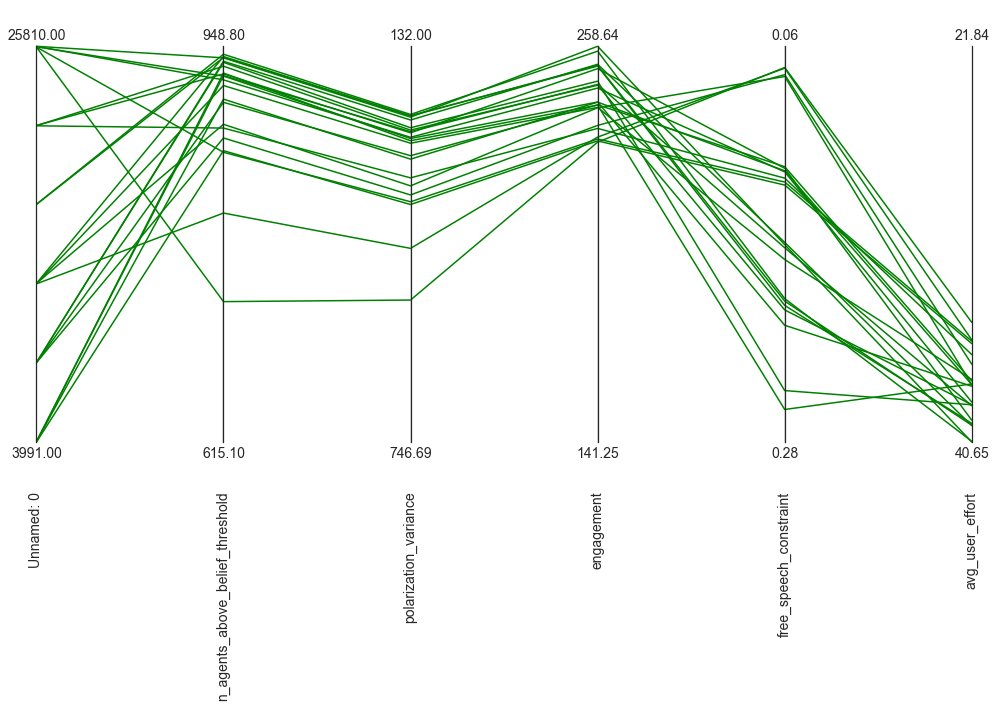

In [16]:
parcoords_outcomes(outcomes_dict, BeliefUpdate.SAMPLE)

##### SIT

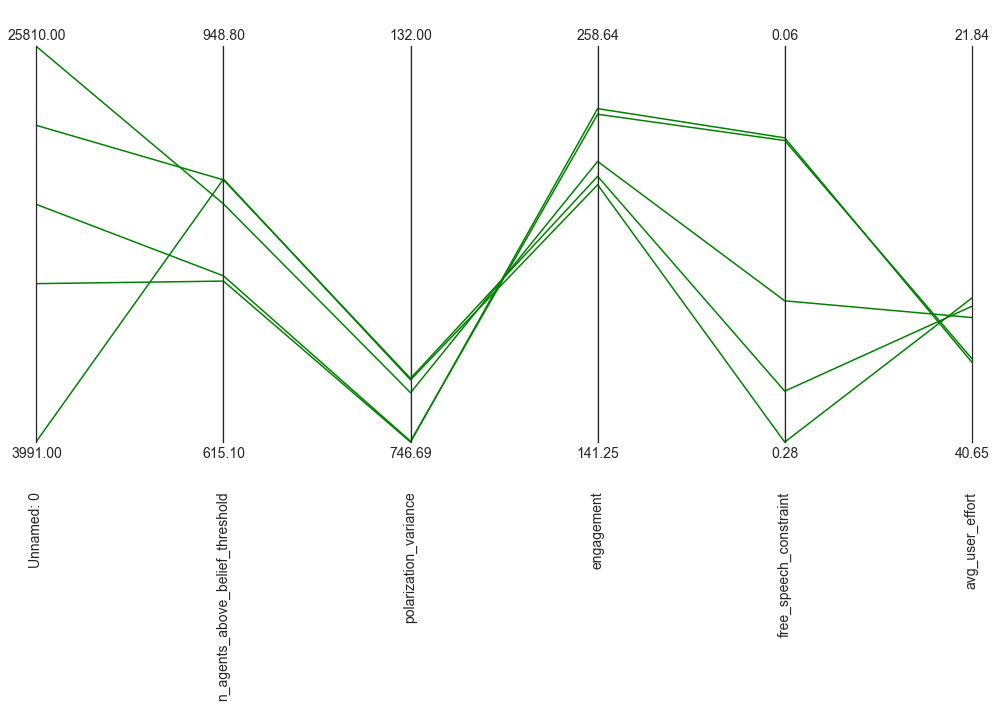

In [17]:
parcoords_outcomes(outcomes_dict, BeliefUpdate.SIT)


##### Combined


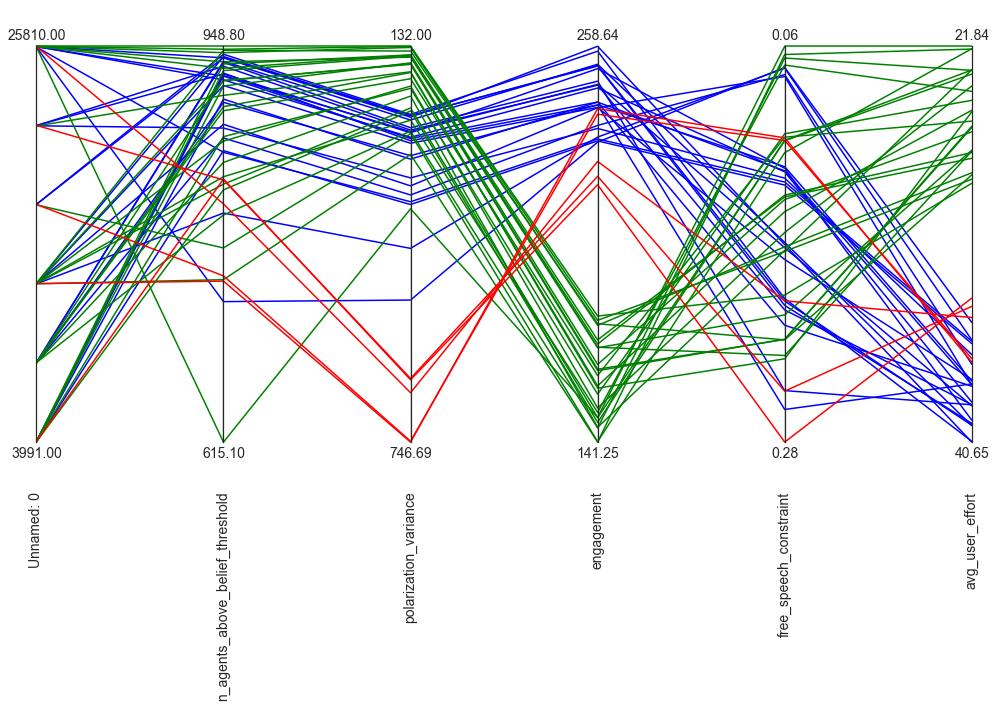

In [25]:

# Get limits
concat_out = pd.concat(outcomes_dict.values())
out_limits = parcoords.get_limits(concat_out)

axes = parcoords.ParallelAxes(out_limits)

minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
for metric in minimize:
    axes.invert_axis(metric)



# Assign each unique model a color
model_names = [x.name for x in list(BeliefUpdate)]
model_colors = {}
colors = ["blue", "green", "red"]

# for _, (model, color) in enumerate(zip(model_names, sns.color_palette("colorblind"))):
for _, (model, color) in enumerate(zip(model_names, colors)):
    model_colors[model] = color


for bufn in list(BeliefUpdate):
    bufn = bufn.name

    color = model_colors[bufn]
    axes.plot(outcomes_dict[bufn], color=color)

In [33]:
print("Color mapping")
for k, v in model_colors.items():
    print(f"{v}: \t {k}")



Color mapping
blue: 	 SAMPLE
green: 	 DEFFUANT
red: 	 SIT


In [18]:
# Below: tried without the "Unnamed: 0" column
# print(outcomes_dict[bufn].columns)
# print(get_outcome_names())
# data = outcomes_dict[bufn]
# data = data[get_outcome_names()]
# print(data)
# # axes.plot(outcomes_dict[bufn][get_outcome_names()])
# axes.plot(data)

In [19]:
# # rescale lever values (0-10 -> 0-100, 0-5 -> 0-50)
# lever_names = get_lever_names()
# for col_name in results.columns:
#     if col_name in lever_names:
#         results[col_name] *= 10
#
# results

In [20]:
# data_dict = {BeliefUpdate.DEFFUANT.name: results}